In [14]:
import nasdaqdatalink
import pandas as pd
import os
from dotenv import load_dotenv

load_dotenv()

df_stocks_otc = pd.read_csv('..'+ os.getenv('over_the_counter'))
df_stocks_nasdaq = pd.read_csv('..'+ os.getenv('nasdaq_data'))

In [46]:
# lets just choose YELLQ
# Obtain the data from otcmarkets.com => traded stocks that are over the counter
df_stocks_otc.loc[df_stocks_otc['Symbol'] == 'YELLQ']


,Symbol,Security Name,Tier,Price,Change %,Vol,Sec Type,Country,State
11868,YELLQ,YELLOW CORP,Pink Current,2.53,15.0,1456529,Common Stock,USA,Utah


<Axes: xlabel='Date'>

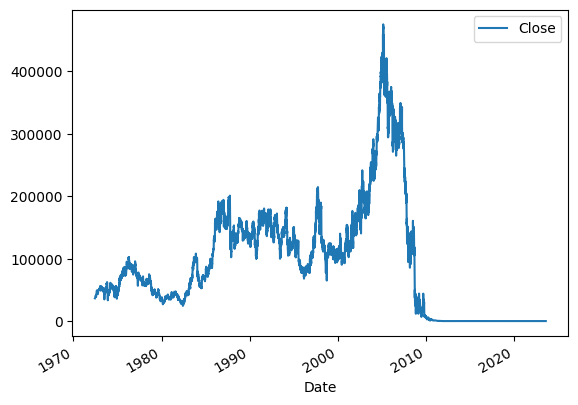

In [55]:
#https://www.youtube.com/watch?v=1O_BenficgE&ab_channel=Dataquest
import yfinance as yf

yellq= yf.Ticker("YELLQ")
yellq_data =yellq.history(period="max")

yellq_data.plot.line(y="Close",use_index=True)

In [57]:
yellq_data["Tomorrow"]=yellq_data["Close"].shift(-1)
yellq_data["Target"] = (yellq_data["Tomorrow"] > yellq_data["Close"]).astype(int)

In [74]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100 , min_samples_split=100,random_state=1)

train = yellq_data.iloc[:-500]
test = yellq_data.iloc[-500:]
predictors=["Close","Volume","Open","High","Low"]
model.fit(train[predictors],train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [78]:
from sklearn.metrics import precision_score
preds = pd.Series(model.predict(test[predictors]),index=test.index)
precision_score(test["Target"],preds)

0.416

<Axes: xlabel='Date'>

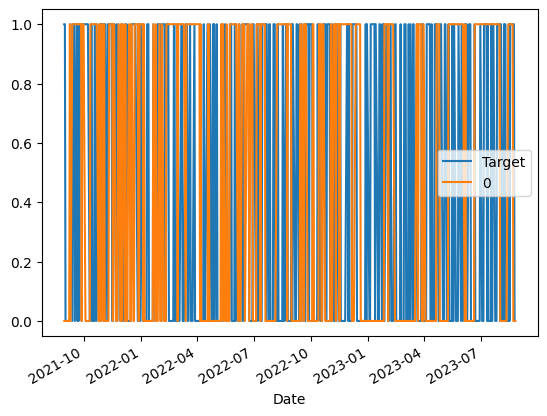

In [82]:
combined = pd.concat([test["Target"],preds],axis=1)
combined.plot()

In [83]:
def predict (train,test,predictors,model):
    model.fit(train[predictors],train["Target"])
    preds =pd.Series( model.predict(test[predictors]),index=test.index,name="Predictions")
    combined = pd.concat([test["Target"],preds],axis=1)
    return combined


In [84]:
def backtest(data,model,predictors,start=2500 , step=250):
    all_predictions = []
    for i in range(start,data.shape[0],step):
        train=data.iloc[0:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predictions = predict(train,test,predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [87]:
predictions = backtest( yellq_data,model,predictors)
predictions["Predictions"].value_counts()

Predictions
0    7005
1    3245
Name: count, dtype: int64

In [88]:
precision_score(predictions["Target"], predictions["Predictions"])

0.45084745762711864

In [89]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
0    0.544585
1    0.455415
Name: count, dtype: float64

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []
for horizon in horizons:
    rolling_averages = yellq_data.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    yellq_data[ratio_column] = yellq_data["Close"] /  rolling_averages["Close"]
    
